# ***Modelos Ligeros***

## **Librerías y carga de datos**


In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = r"/content/drive/MyDrive/PDG/data/"
#root_dir = '/content/drive/MyDrive/aaa/'
#root_dir = "/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"

In [4]:
file_original = root_dir + "base_df.xlsx"
file_aug_train = root_dir + "train_oversample_df.xlsx"
file_aug_val  = root_dir + "val_df.xlsx"

## **Preprocesamiento**

In [5]:
TEXT   = "texto"
LABEL  = "etiqueta"

In [6]:
tfidf = TfidfVectorizer(
    max_features=20_000,
    ngram_range=(1,2),
    min_df=3,
    sublinear_tf=True
)

In [7]:
prepro = ColumnTransformer(
    transformers=[("tfidf", tfidf, TEXT)],
    remainder="drop"
)

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **Métricas**

In [9]:
scoring = {
    "precision": make_scorer(precision_score, zero_division=0),
    "recall"   : make_scorer(recall_score,    zero_division=0),
    "f1"       : make_scorer(f1_score,        zero_division=0)
}

## **Modelos**

In [10]:
models_grids = {
    "NaiveBayes": (
        MultinomialNB(),
        {"clf__alpha": [0.1, 0.5, 1.0]}
    ),
    "LogReg": (
        LogisticRegression(max_iter=1000, class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    ),
    "LinearSVM": (
        LinearSVC(class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    )
}

## **Grid**

In [11]:
def grid_search_models(X_tr, y_tr):
    best = {}
    for name, (clf, grid) in models_grids.items():
        pipe = Pipeline([("prep", prepro), ("clf", clf)])
        gs   = GridSearchCV(
            pipe, grid,
            scoring=scoring,
            refit="recall",
            cv=cv,
            n_jobs=-1, verbose=0
        )
        gs.fit(X_tr, y_tr)
        best[name] = gs.best_estimator_
        print(f"{name}: recall CV={gs.best_score_:.3f} | params={gs.best_params_}")
    return best

def evaluate_on_test(models, X_te, y_te, scenario):
    for name, model in models.items():
        y_pred = model.predict(X_te)
        print(f"\n=== {name} – {scenario} ===")
        print(classification_report(y_te, y_pred, digits=3))
        cm = confusion_matrix(y_te, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=["No crítico","Crítico"]).plot(cmap="Blues")
        plt.title(f"CM – {name} ({scenario})")
        plt.show()

## **Dataset Original**


Grid-search (ORIGINAL)…
NaiveBayes: recall CV=0.837 | params={'clf__alpha': 0.1}
LogReg: recall CV=0.875 | params={'clf__C': 1}
LinearSVM: recall CV=0.879 | params={'clf__C': 0.1}

Evaluación en test (ORIGINAL)

=== NaiveBayes – Original ===
              precision    recall  f1-score   support

           0      0.950     0.897     0.923       535
           1      0.643     0.798     0.712       124

    accuracy                          0.879       659
   macro avg      0.797     0.848     0.818       659
weighted avg      0.893     0.879     0.883       659



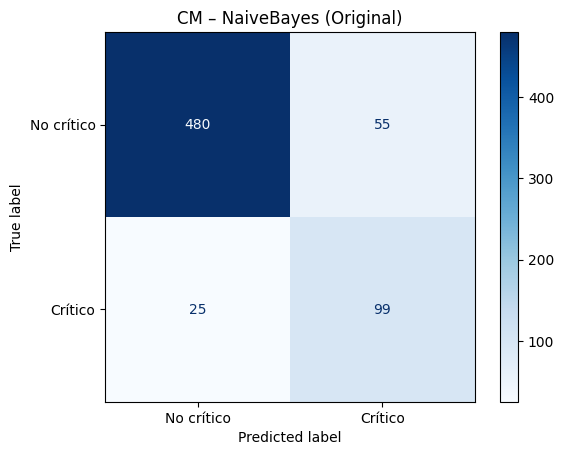


=== LogReg – Original ===
              precision    recall  f1-score   support

           0      0.974     0.908     0.940       535
           1      0.694     0.895     0.782       124

    accuracy                          0.906       659
   macro avg      0.834     0.902     0.861       659
weighted avg      0.921     0.906     0.910       659



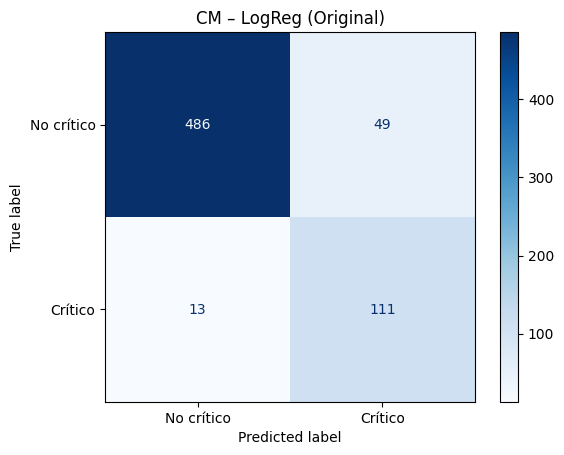


=== LinearSVM – Original ===
              precision    recall  f1-score   support

           0      0.974     0.912     0.942       535
           1      0.703     0.895     0.787       124

    accuracy                          0.909       659
   macro avg      0.838     0.904     0.865       659
weighted avg      0.923     0.909     0.913       659



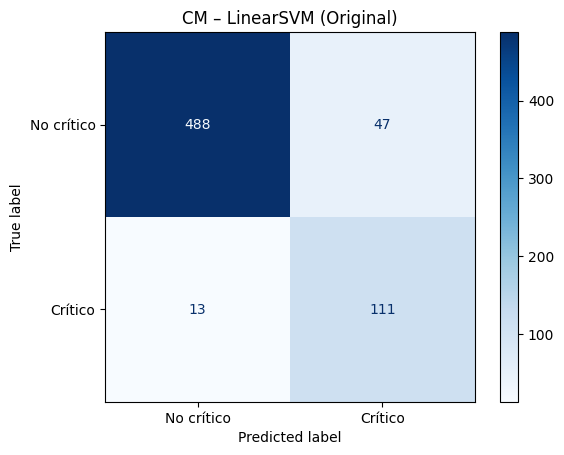

In [12]:
df_orig = pd.read_excel(file_original)

Xo = df_orig[[TEXT]]
yo = df_orig[LABEL].values
Xo_tr, Xo_te, yo_tr, yo_te = train_test_split(
    Xo, yo, test_size=0.2, stratify=yo, random_state=42
)

print("\nGrid-search (ORIGINAL)…")
models_orig = grid_search_models(Xo_tr, yo_tr)

print("\nEvaluación en test (ORIGINAL)")
evaluate_on_test(models_orig, Xo_te, yo_te, "Original")

## **Datased Aumentado**

In [13]:
df_tr = pd.read_excel(file_aug_train)
df_te = pd.read_excel(file_aug_val)

In [14]:
df_tr

,texto,etiqueta
0,cardiopatia compleja. surcos y circunvolucione...,0
1,el paciente presenta un traumatismo craneoence...,1
2,cefalea surcos y circunvoluciones simetricos. ...,0
3,se sospecha de un accidente cerebrovascular - ...,1
4,"acv previo, trombocitopenia, anticoagulada con...",0
...,...,...
3378,desorientacion. prominencia de surcos y cisura...,0
3379,antecedente de tce: ahora confuso: a descartar...,0
3380,cefalea intensa en paciente anticoagulado. sur...,0
3381,cefalea. antecedente de hemorragia subaracnoid...,0


In [15]:
df_te

,texto,etiqueta
0,ea- hta- dm- enfermedad coronaria- somnolencia...,0
1,"seguimiento postquirurgico, drenaje coleccion ...",1
2,antecedente de trauma craneal e inestabilidad ...,0
3,posible sindrome de demencial. prominencia de ...,0
4,asimetria facial y craneana.sinofris. surcos y...,0
...,...,...
654,cefalea en estudio. surcos y circunvoluciones ...,0
655,cefalea en estudio. surcos y circunvoluciones ...,0
656,"paciente con hemorragia subaracnoidea, descart...",1
657,nr la atenuacion del parenquima es normal para...,0



 Grid-search (AUMENTADO)…
NaiveBayes: recall CV=0.945 | params={'clf__alpha': 0.1}
LogReg: recall CV=0.947 | params={'clf__C': 10}
LinearSVM: recall CV=0.953 | params={'clf__C': 10}

 Evaluación en test (AUMENTADO)

=== NaiveBayes – Aumentado ===
              precision    recall  f1-score   support

           0      0.928     0.957     0.942       535
           1      0.785     0.677     0.727       124

    accuracy                          0.904       659
   macro avg      0.856     0.817     0.835       659
weighted avg      0.901     0.904     0.902       659



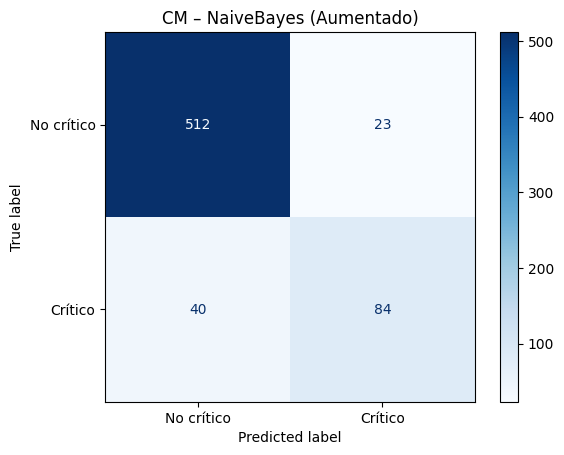


=== LogReg – Aumentado ===
              precision    recall  f1-score   support

           0      0.950     0.959     0.954       535
           1      0.815     0.782     0.798       124

    accuracy                          0.926       659
   macro avg      0.883     0.871     0.876       659
weighted avg      0.925     0.926     0.925       659



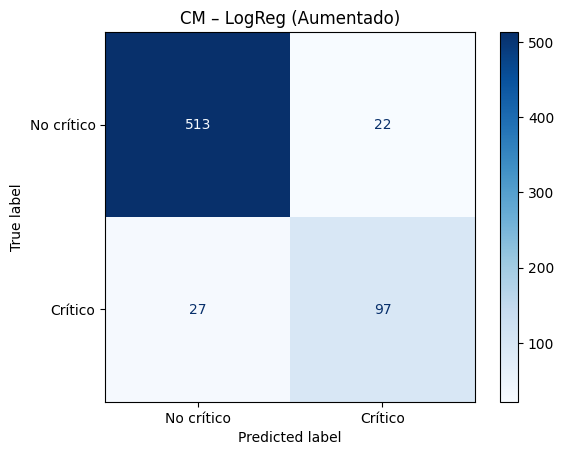


=== LinearSVM – Aumentado ===
              precision    recall  f1-score   support

           0      0.950     0.968     0.959       535
           1      0.851     0.782     0.815       124

    accuracy                          0.933       659
   macro avg      0.901     0.875     0.887       659
weighted avg      0.932     0.933     0.932       659



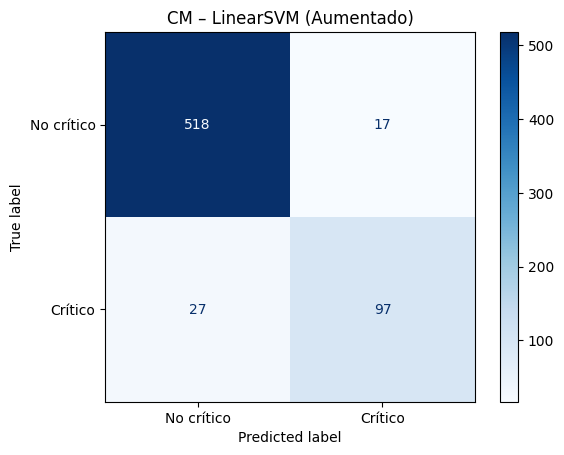

In [16]:
Xa_tr, ya_tr = df_tr, df_tr[LABEL].values
Xa_te, ya_te = df_te, df_te[LABEL].values

print("\n Grid-search (AUMENTADO)…")
models_aug = grid_search_models(Xa_tr, ya_tr)

print("\n Evaluación en test (AUMENTADO)")
evaluate_on_test(models_aug, Xa_te, ya_te, "Aumentado")
